# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

![alt text](image-5.png)

Precisión:

Mide: La proporción de predicciones positivas correctas (cuántos mensajes clasificados como "spam" son realmente spam).

Resultados:

n_estimators=50: 0.97390

n_estimators=100: 0.97500

n_estimators=200: 0.97729

Conclusión: Aumentar el número de árboles mejora ligeramente la precisión, pero la mejora es marginal

![alt text](image-7.png)

F1-score

Mide: El equilibrio entre precisión y recall (útil cuando hay desequilibrio entre clases).

Resultados:

n_estimators=50: 0.97272

n_estimators=100: 0.97474

n_estimators=200: 0.97779

Conclusión: El F1-score mejora con más árboles, pero la diferencia entre 100 y 200 es pequeña.


![alt text](image-6.png)

Recall

Mide: La proporción de casos positivos reales identificados correctamente (cuántos mensajes de spam reales fueron detectados).

Resultados:

n_estimators=50: 0.97300

n_estimators=100: 0.97400

n_estimators=200: 0.97668

Conclusión: El recall mejora ligeramente con más árboles, pero la ganancia es mínima.

Resumen General

Tendencia: Más árboles (n_estimators) mejoran ligeramente todas las métricas (precisión, F1-score y recall).

Recomendación: n_estimators=100 ofrece un buen equilibrio entre rendimiento y eficiencia, ya que las métricas son muy cercanas a las de 200 árboles, pero con menos costo computacional.

Conclusión Final: A menos que necesitemps maximizar el rendimiento a cualquier costo, n_estimators=100 es la mejor opción.

## Generar .py de funciones y main con al menos dos argumentos de entrada.

In [ ]:
# sms_spam_classification.py

import pandas as pd
import re
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import argparse

def cargar_y_limpiar_datos(ruta_archivo):
    """
    Carga el archivo CSV y realiza una limpieza básica del texto.
    """
    df = pd.read_csv("spam.csv", encoding="latin-1")
    df = df.rename(columns={"v1": "label", "v2": "text"})
    df = df[["label", "text"]]

    def limpiar_texto(texto):
        texto = texto.lower()
        texto = re.sub(r"[^a-zA-Z\s]", "", texto)
        return texto

    df["text_clean"] = df["text"].apply(limpiar_texto)
    return df

def entrenar_y_evaluar_modelo(df, n_estimators):
    """
    Entrena un modelo de Random Forest y lo evalúa.
    """
    # Dividir los datos
    X = df["text_clean"]
    y = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Crear el pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english")),
        ("clf", RandomForestClassifier(n_estimators=n_estimators, random_state=42))
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    # Mostrar resultados
    print(f"\n=== Resultados para n_estimators={n_estimators} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

    return pipeline, precision, recall, f1

def guardar_modelo_en_mlflow(pipeline, n_estimators, precision, recall, f1):
    """
    Guarda el modelo y las métricas en MLflow.
    """
    with mlflow.start_run():
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(pipeline, f"modelo_sms_spam_rf_n{n_estimators}")
        print(f"Modelo y métricas registrados en MLflow para n_estimators={n_estimators}.")

def main():
    # Configurar el parser de argumentos
    parser = argparse.ArgumentParser(description="Clasificación de SMS Spam usando Random Forest.")
    parser.add_argument("--ruta_archivo", type=str, required=True, help="Ruta del archivo CSV con los datos")
    parser.add_argument("--n_estimators", type=int, default=100, help="Número de estimadores para Random Forest")
    
    # Parsear los argumentos
    args = parser.parse_args()

    # Cargar y limpiar los datos
    df = cargar_y_limpiar_datos(args.ruta_archivo)

    # Entrenar y evaluar el modelo
    pipeline, precision, recall, f1 = entrenar_y_evaluar_modelo(df, args.n_estimators)

    # Guardar el modelo en MLflow
    guardar_modelo_en_mlflow(pipeline, args.n_estimators, precision, recall, f1)

# Ejecutar el bloque main si el script se ejecuta directamente
if __name__ == "__main__":
    main()


#output
#python sms_spam_classification.py --ruta_archivo spam.csv --n_estimators 100

=== Resultados para n_estimators=100 ===
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Matriz de Confusión:
[[966   0]
 [ 30 119]]
Downloading artifacts: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

![alt text](image-8.png)
![alt text](image-10.png)

![alt text](image-9.png)
![alt text](image-11.png)

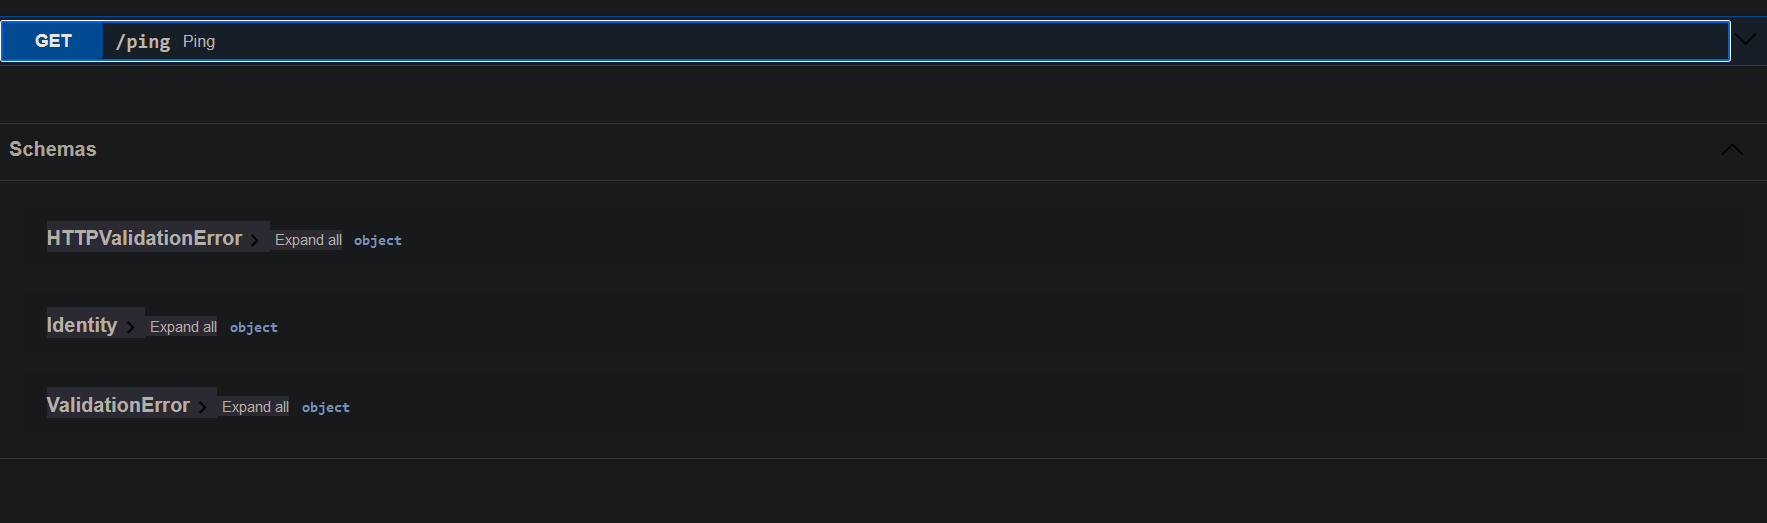
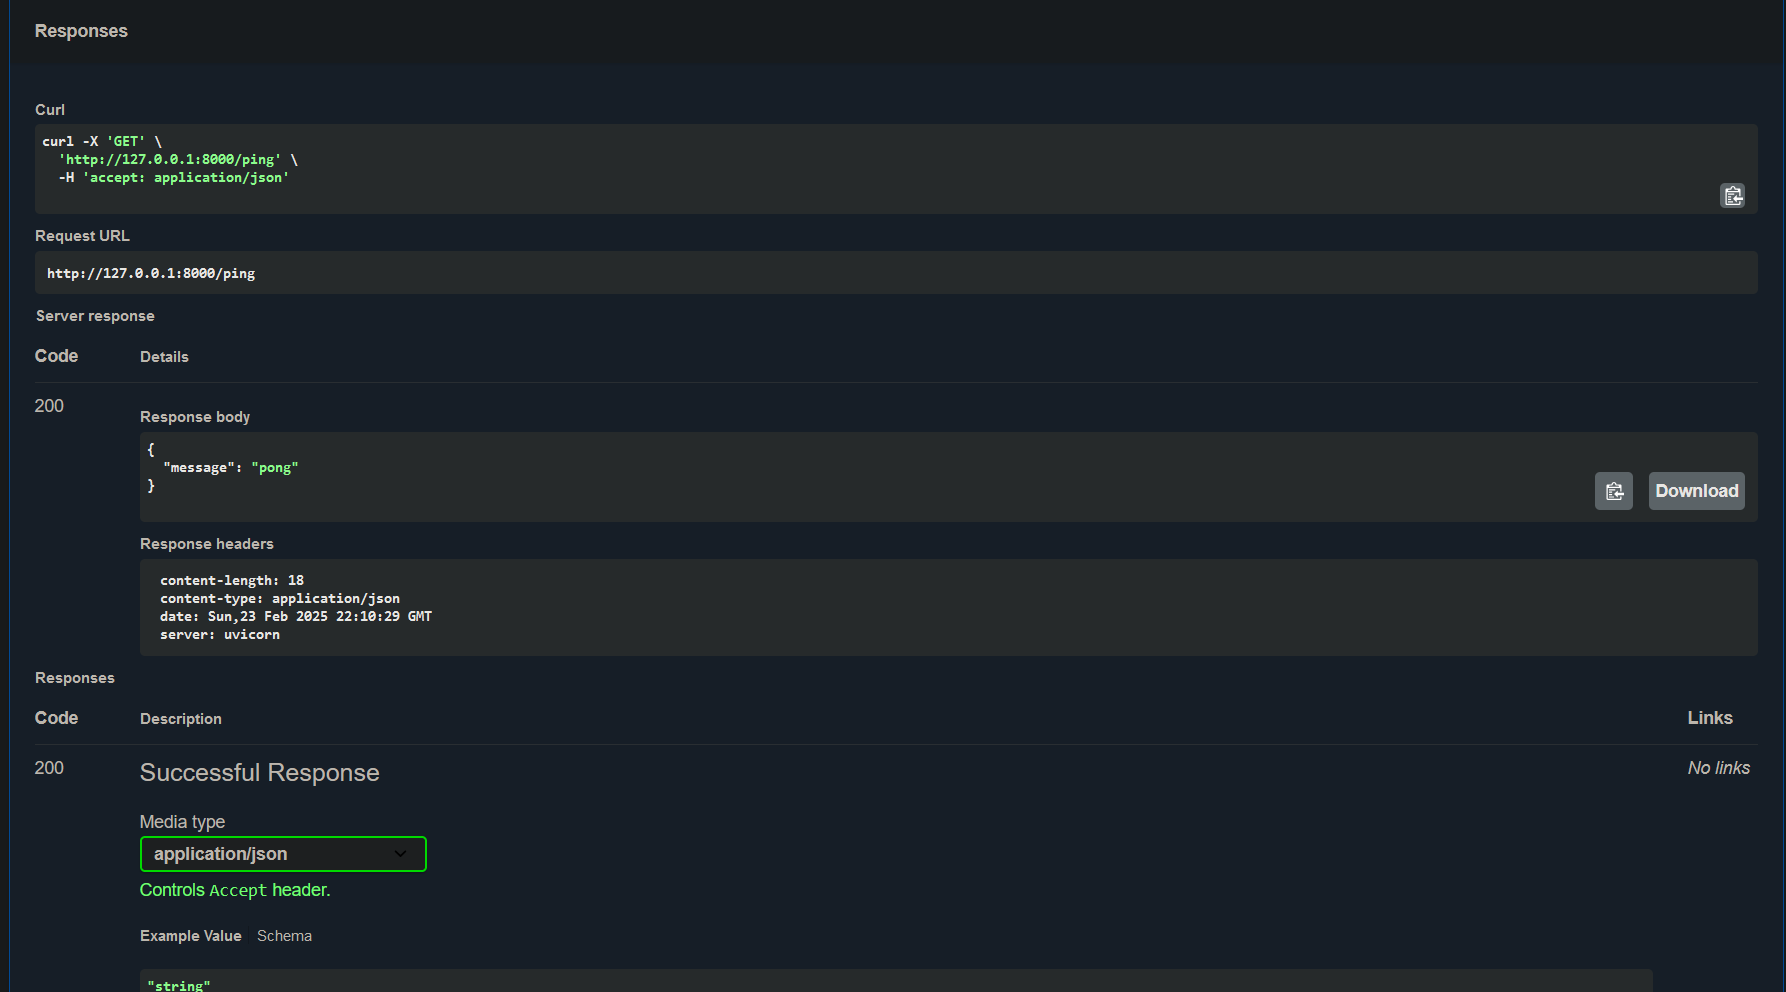

![alt text](image-12.png)
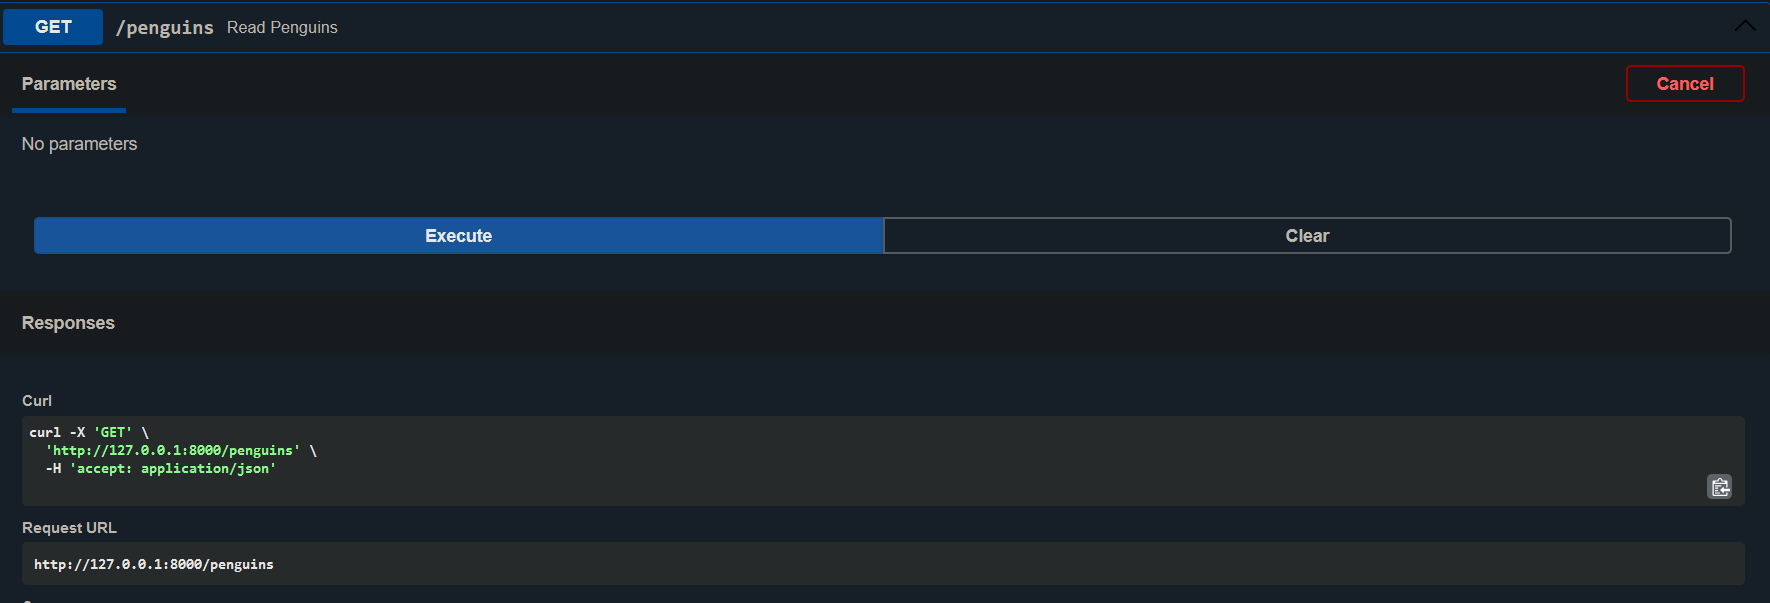